In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import folium
import os
import numpy as np
import matplotlib.colors as mcolors
%matplotlib inline

In [3]:
# Load the shapefiles
gdf1 = gpd.read_file(glob.glob("/mnt/Ddrive/projects/superparcels/outputs/06075/*dt30*.shp")[0])
gdf2 = gpd.read_file(glob.glob("/mnt/Ddrive/projects/superparcels/outputs/06075/*dt50*.shp")[0])
gdf3 = gpd.read_file(glob.glob("/mnt/Ddrive/projects/superparcels/outputs/06075/*dt75*.shp")[0])
gdf4 = gpd.read_file(glob.glob("/mnt/Ddrive/projects/superparcels/outputs/06075/*dt100*.shp")[0])
gdf5 = gpd.read_file(glob.glob("/mnt/Ddrive/projects/superparcels/outputs/06075/*dt150*.shp")[0])
gdf6 = gpd.read_file(glob.glob("/mnt/Ddrive/projects/superparcels/outputs/06075/*dt200*.shp")[0])
#ref_candidates = gpd.read_file(glob.glob("/mnt/Ddrive/projects/superparcels/inputs/55107/*.shp")[0])

In [4]:
display(gdf1.shape, gdf2.shape, gdf3.shape, gdf4.shape, gdf5.shape, gdf6.shape)

(1004, 4)

(1057, 4)

(1134, 4)

(1241, 4)

(1419, 4)

(1574, 4)

Spatial Join each distance threshold on itself using the OVERLAP predicate. The OVERLAP is TRUE if two polygons share some area but do not CONTAIN one another. 

In [5]:
gdf6 = gdf6.reset_index()

In [6]:
sjoin = gpd.sjoin(gdf6, gdf6, how='left', predicate='overlaps')[['index_left', 'sp_id_left', 'owner_left', 'index_right', 'owner_right', 'geometry']]

In [7]:
sjoin.head()

,index_left,sp_id_left,owner_left,index_right,owner_right,geometry
0,0,1035 MARKET LLC_0_0,1035 MARKET LLC,NaN,NaN,"POLYGON ((551886.311 4181679.839, 551850.892 4..."
1,1,1215 RHODE ISLAND_0_0,1215 RHODE ISLAND,NaN,NaN,"POLYGON ((552629.772 4178878.699, 552628.942 4..."
2,2,1215 RHODE ISLAND_0_1,1215 RHODE ISLAND,NaN,NaN,"POLYGON ((552727.308 4178736.516, 552757.685 4..."
3,3,1233 FOLSOM STREET LLC_0_0,1233 FOLSOM STREET LLC,NaN,NaN,"POLYGON ((551945.118 4180917.453, 551928.98 41..."
4,4,1234 GREAT HIGHWAY LLC_0_0,1234 GREAT HIGHWAY LLC,NaN,NaN,"POLYGON ((543194.563 4179609.656, 543188.611 4..."


Remove instances where the geometry overlaps itself or where the spatial join did not hit anything

In [8]:
mismatch = sjoin[sjoin['owner_left'] != sjoin['owner_right']]
mismatch = mismatch[mismatch['owner_right'].notnull()]
mismatch.head()


,index_left,sp_id_left,owner_left,index_right,owner_right,geometry
5,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,428.0,CITY & COUNTY OF SAN FRANCISCO,"POLYGON ((554328.97 4176850.731, 554409.179 41..."
5,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,1069.0,NORTHRIDGE COOPERATIVE HOMES,"POLYGON ((554328.97 4176850.731, 554409.179 41..."
5,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,712.0,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554328.97 4176850.731, 554409.179 41..."
5,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,711.0,HUNTERS VIEW ASSOCIATES,"POLYGON ((554328.97 4176850.731, 554409.179 41..."
5,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,713.0,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554328.97 4176850.731, 554409.179 41..."


Join mismatches back to original geodataframe to obtain the *other* geometry that overlapped. There now should be the key geometry (geometry_x) and the *other* geometry (geometry_y)

In [9]:
sjoin_right = pd.merge(mismatch, gdf6[['index', 'owner', 'geometry']], left_on='index_right', right_on='index', how='inner')
sjoin_right.head()

,index_left,sp_id_left,owner_left,index_right,owner_right,geometry_x,index,owner,geometry_y
0,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,428.0,CITY & COUNTY OF SAN FRANCISCO,"POLYGON ((554328.97 4176850.731, 554409.179 41...",428,CITY & COUNTY OF SAN FRANCISCO,"POLYGON ((554214.308 4176499.052, 554247.448 4..."
1,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,1069.0,NORTHRIDGE COOPERATIVE HOMES,"POLYGON ((554328.97 4176850.731, 554409.179 41...",1069,NORTHRIDGE COOPERATIVE HOMES,"POLYGON ((554387.205 4176534.472, 554365.788 4..."
2,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,712.0,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554328.97 4176850.731, 554409.179 41...",712,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554465.283 4176699.164, 554498.228 4..."
3,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,711.0,HUNTERS VIEW ASSOCIATES,"POLYGON ((554328.97 4176850.731, 554409.179 41...",711,HUNTERS VIEW ASSOCIATES,"POLYGON ((554486.814 4176727.928, 554517.903 4..."
4,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,713.0,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554328.97 4176850.731, 554409.179 41...",713,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554509.12 4176775.604, 554428.882 41..."


Create a new geometry based on the intersection of the two geometries. This geoemtry is the overlap. Calcualte the area or size.

In [10]:
sjoin_right['diff_area'] = sjoin_right.apply(lambda x: x['geometry_x'].intersection(x['geometry_y']).area, axis=1)
sjoin_right.head()


,index_left,sp_id_left,owner_left,index_right,owner_right,geometry_x,index,owner,geometry_y,diff_area
0,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,428.0,CITY & COUNTY OF SAN FRANCISCO,"POLYGON ((554328.97 4176850.731, 554409.179 41...",428,CITY & COUNTY OF SAN FRANCISCO,"POLYGON ((554214.308 4176499.052, 554247.448 4...",1.199547e+03
1,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,1069.0,NORTHRIDGE COOPERATIVE HOMES,"POLYGON ((554328.97 4176850.731, 554409.179 41...",1069,NORTHRIDGE COOPERATIVE HOMES,"POLYGON ((554387.205 4176534.472, 554365.788 4...",0.000000e+00
2,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,712.0,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554328.97 4176850.731, 554409.179 41...",712,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554465.283 4176699.164, 554498.228 4...",3.268892e-03
3,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,711.0,HUNTERS VIEW ASSOCIATES,"POLYGON ((554328.97 4176850.731, 554409.179 41...",711,HUNTERS VIEW ASSOCIATES,"POLYGON ((554486.814 4176727.928, 554517.903 4...",3.871034e-09
4,5,1340 HUDSON AVENUE_0_0,1340 HUDSON AVENUE,713.0,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554328.97 4176850.731, 554409.179 41...",713,HV COMMUNITY ASSOCIATION INC,"POLYGON ((554509.12 4176775.604, 554428.882 41...",8.989133e-04


Because the overlap will be TRUE if any slight deviation in coordinates, we need to remove the insignificant overlap geometries  -- inother words any area less than ~ 1 meter.

In [11]:
overlaps = sjoin_right[sjoin_right['diff_area'] > 1]

Now that we have our final overlap dataframe, we can extract the unique intersections based on our key owner field (_left) and how many *other* owner fields by using a groupby function.

In [12]:
gb = overlaps.groupby('owner_left')['owner_right'].nunique()

Results

In [13]:
data_dict = {
            f'{1}_overlaps': gb.sum(),
            f'{1}_sp_count': len(gdf6),
            f'{1}_pct_overlap': gb.sum() / len(gdf6) * 100,
            f'{1}_avg_overlap': gb.mean()
        }

df1 = pd.DataFrame(data_dict, index=[0])
df1.index = ['55107']
df1

,1_overlaps,1_sp_count,1_pct_overlap,1_avg_overlap
55107,596,1574,37.865311,2.46281


In [14]:
dt_overlap = pd.read_csv('/mnt/Ddrive/projects/superparcels/outputs/dt_overlap_analysis.csv', index_col=0)
dt_overlap

,30_overlaps,30_sp_count,30_pct_overlap,30_avg_overlap,50_overlaps,50_sp_count,50_pct_overlap,50_avg_overlap,75_overlaps,75_sp_count,...,100_pct_overlap,100_avg_overlap,150_overlaps,150_sp_count,150_pct_overlap,150_avg_overlap,200_overlaps,200_sp_count,200_pct_overlap,200_avg_overlap
8031,384,1721,22.312609,1.366548,540,1759,30.699261,1.504178,692,1840,...,43.970894,1.649123,1080,2041,52.915238,1.794020,1344,2076,64.739884,1.887640
35051,14,287,4.878049,1.272727,20,322,6.211180,1.176471,44,339,...,16.470588,1.166667,70,339,20.648968,1.186441,120,355,33.802817,1.276596
16001,766,4142,18.493481,1.318417,1074,3941,27.251967,1.389392,1488,3888,...,45.461721,1.522467,2166,3790,57.150396,1.621257,2576,3812,67.576076,1.715047
6037,4040,25176,16.047029,1.328510,6426,25543,25.157577,1.488534,8472,26115,...,38.800930,1.675089,13452,27715,48.536893,1.791689,15620,28543,54.724451,1.869092
41013,70,576,12.152778,1.186441,90,577,15.597920,1.216216,112,572,...,23.168654,1.283019,192,586,32.764505,1.381295,278,612,45.424837,1.470899
6091,58,261,22.222222,1.414634,90,241,37.344398,1.578947,100,299,...,49.593496,1.605263,150,273,54.945055,1.685393,206,260,79.230769,1.943396
6075,138,1004,13.745020,1.326923,230,1057,21.759697,1.503268,328,1134,...,31.587429,1.626556,542,1419,38.195913,1.662577,764,1574,48.538755,1.801887
55107,180,2466,7.299270,1.097561,330,2492,13.242376,1.217712,402,2488,...,19.992035,1.255000,654,2511,26.045400,1.348454,852,2513,33.903701,1.378641
48113,1360,7687,17.692208,1.360000,2262,7944,28.474320,1.494055,3084,8326,...,43.387228,1.681695,4718,9054,52.109565,1.785768,5842,9485,61.591987,1.876044
20097,8,286,2.797203,1.142857,28,302,9.271523,1.166667,36,316,...,12.422360,1.142857,88,333,26.426426,1.543860,114,349,32.664756,1.583333


In [15]:
oc = pd.read_csv('/mnt/Ddrive/projects/superparcels/outputs/owner_count_analysis.csv', index_col=0)
oc

,30,50,75,100,150,200
8031,1034,1078,1130,1147,1201,1241
35051,206,226,235,242,254,266
16001,2323,2416,2506,2561,2644,2684
6037,18018,18574,19021,19354,19891,20306
41013,369,378,385,391,397,403
6091,104,109,109,111,113,116
6075,657,694,724,756,804,844
55107,2038,2061,2072,2084,2096,2109
48113,5356,5625,5847,5986,6243,6404
20097,210,218,225,230,236,240


In [16]:
def zfill(s, width):
    return s.zfill(width)

def fill_fips(df):
    indexes = df.index
    idx_list = []
    for i in indexes:
        if len(str(i)) == 4:
            i = zfill(str(i), 5)
        idx_list.append(i)

    # convert all elements to str
    idx_list = [str(i) for i in idx_list]
    df.index = idx_list

    return df
    

In [17]:
dt_overlap = fill_fips(dt_overlap)
oc = fill_fips(oc)

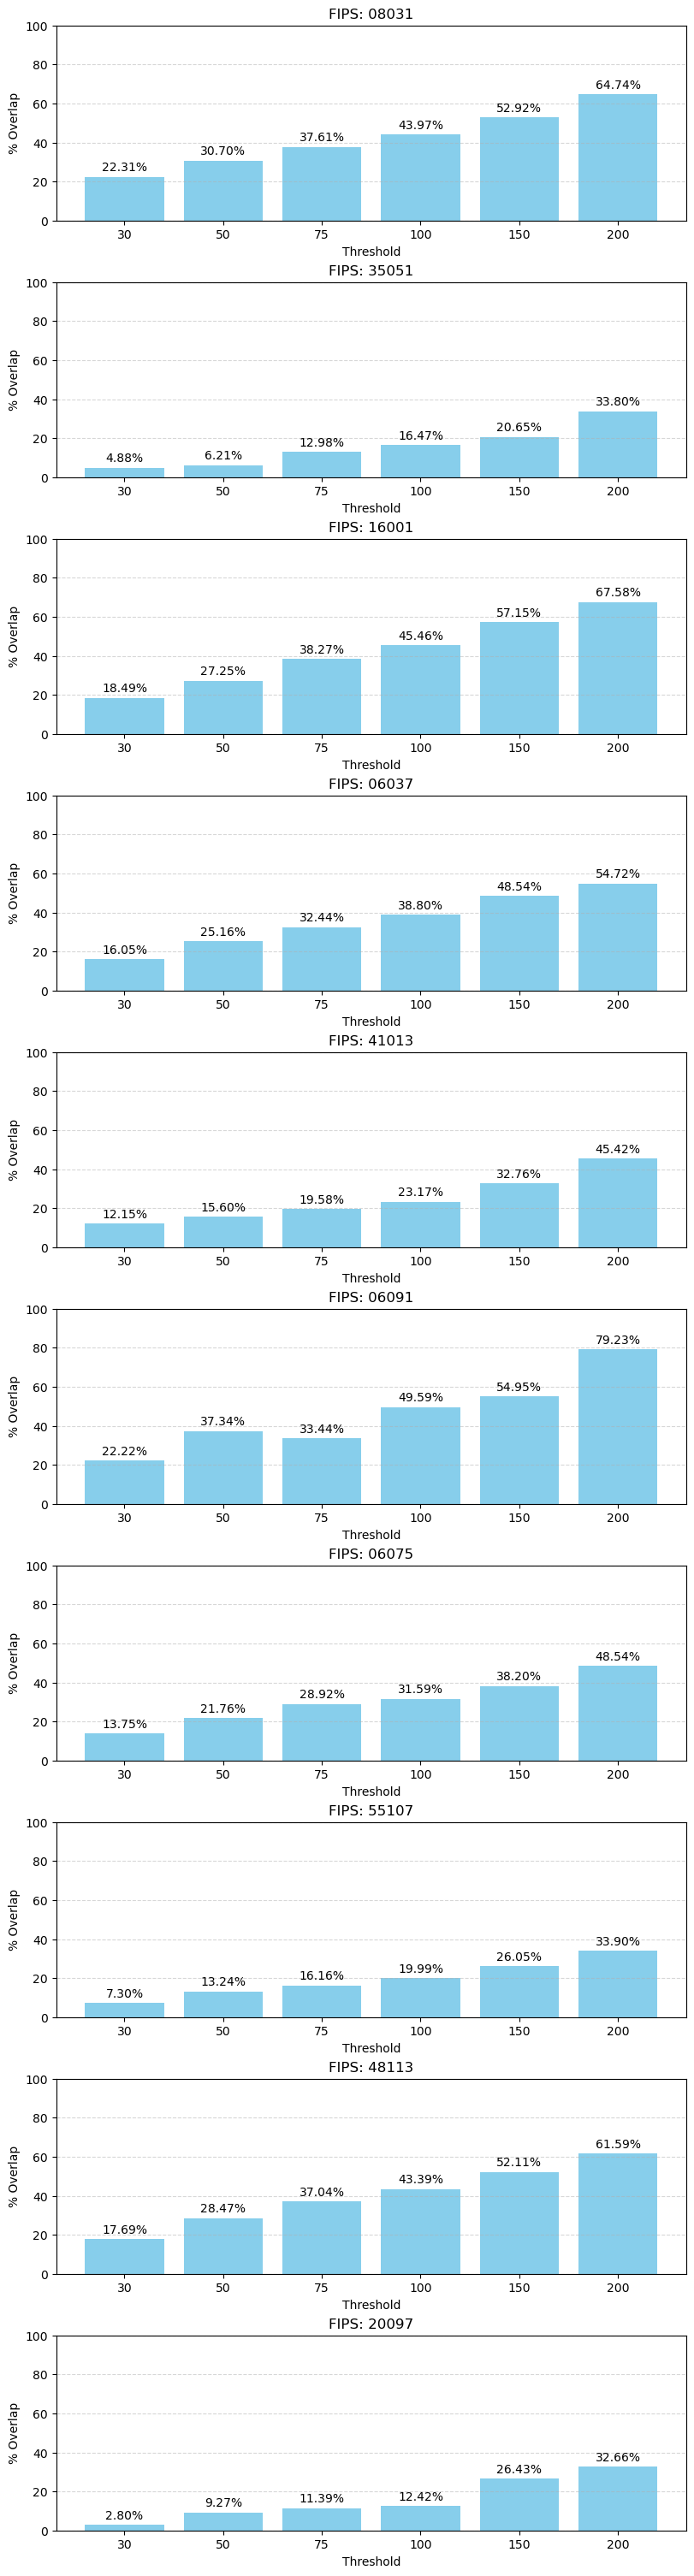

In [18]:
# Extract all thresholds based on column names that include 'pct_overlap'
thresholds = sorted([
    int(col.split('_')[0]) for col in dt_overlap.columns if 'pct_overlap' in col
])

# Plotting
num_fips = len(dt_overlap)
fig, axes = plt.subplots(num_fips, 1, figsize=(8, 3 * num_fips), constrained_layout=True)

if num_fips == 1:
    axes = [axes]  # Make iterable if only one

for ax, (fips, row) in zip(axes, dt_overlap.iterrows()):
    pct_overlaps = [row[f"{t}_pct_overlap"] for t in thresholds]
    threshold_labels = [str(t) for t in thresholds]

    bars = ax.bar(threshold_labels, pct_overlaps, color='skyblue')
    ax.set_title(f"FIPS: {fips}")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("% Overlap")
    ax.set_ylim(0, 100)  # Adjust if your values exceed 100
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Add bar labels
    ax.bar_label(bars, labels=[f"{val:.2f}%" for val in pct_overlaps], padding=3)

plt.show()


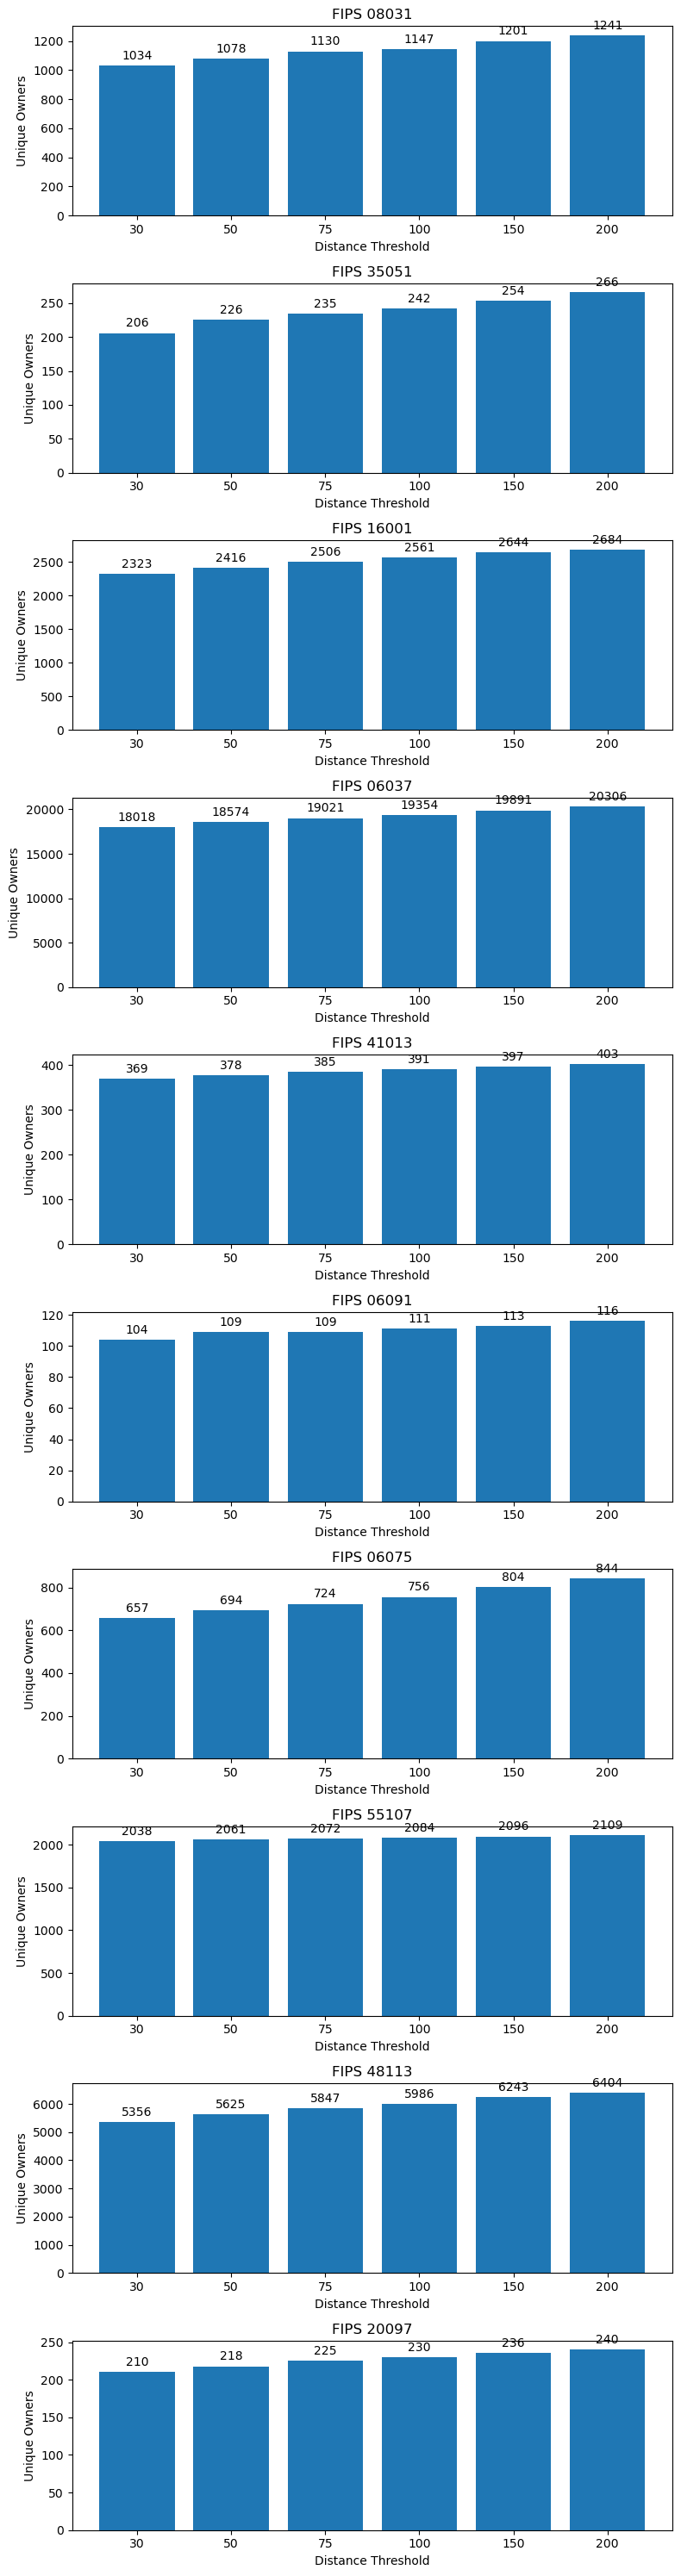

In [19]:
# Separate the index values and bar values
indexes = oc.index.to_list()
bar_values = oc.values

# Create one subplot for each row in the oc
nrows = oc.shape[0]
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(8, 3*nrows))

# In case there is only one row, ensure axes is iterable.
if nrows == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    # Create the bar plot for the current row
    bars = ax.bar(oc.columns.to_list(), bar_values[i])
   
    ax.bar_label(bars, padding=3)
    
    # Set the title of the subplot to show the index value
    ax.set_title(f"FIPS {indexes[i]}")
    
    # Optionally, label axes
    ax.set_xlabel("Distance Threshold")
    ax.set_ylabel("Unique Owners")

plt.tight_layout()
plt.show()
